In [16]:
import os
import netCDF4 as nc
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import string

In [17]:
def read_nc_var(path,file_name,var_name):
    file2read = nc.Dataset(path+file_name,'r')
    var1 = file2read.variables[var_name]
    time = file2read.variables["time"]
    return var1, time
def read_nc_var_notime(path,file_name,var_name):
    file2read = nc.Dataset(path+file_name,'r')
    var1 = file2read.variables[var_name]
    return var1

#def runmean(x, N):
#    cumsum = np.cumsum(np.insert(x, 0, 0)) 
#    return (cumsum[N:] - cumsum[:-N]) / float(N)

def runmean(array, winlen):
    """Calculates a running mean of any timeseries using a window
    length (winlen).
    Args:
        array: timeseries over which the running mean is calculated
        winlen: window length of running mean
    """
    return np.convolve(array, np.ones((winlen)) / winlen, mode='same')


def extrapolated_runmean(array, winlen):
    """Extrapolates a running mean at the beginning and end of the 
    time series. At the beginning, the window size is simply reduced. 
    At the end, which is critical for the t_anth estimation at the 
    stocktake, the running mean is linearly extrapolated. This is 
    done by calculating the slope over the last 31 (generally winlen) 
    years and adding a linear spline with this slope to the last 
    valid running mean value 17 (generally int(winlen / 2) +1) years 
    before stocktake to obtain the estimates for the last 15 
    (generally int(winlen / 2)) years before stocktake.
    Args:
        array: timeseries over which the running mean is calculated
        winlen: window length of running mean
    """
    winlen=15
    array_runmean = runmean(array, winlen)

    # Reduce window size down to int(winlen / 2) + 1
    # for the first int(winlen / 2) elements.
    array_runmean[:int(winlen / 2)] = np.array([
        np.mean(array[:int(winlen / 2) + i + 1])
        for i in range(int(winlen / 2))
    ])

    # Replace the last int(winlen / 2) elements by a linear extrapolation.
    array_runmean[-int(winlen / 2):] =\
        array_runmean[-int(winlen / 2) - 1]\
        + np.polyfit(np.arange(winlen), array[-winlen:], deg=1)[0]\
        * np.arange(1, int(winlen / 2) + 1)

    return array_runmean

def extrapolate_until_2000(array,startyear,years):
    winlen=15
    
    length_ts_1905_2020 = 2022-startyear 
    
    array_extrapolated = np.zeros(length_ts_1905_2020)
    array_extrapolated[0:len(years)] = array[0:len(years)]
    
    years_missing=2022-(startyear+len(years))
    array_extrapolated[-years_missing:]=array[-1]\
    + np.polyfit(np.arange(years_missing), array[-years_missing:], deg=1)[0]\
    * np.arange(1, years_missing + 1 )
    return array_extrapolated

def intermediate_point(start_point,end_point,uncertainty,slope_sign):
    point = start_point + (end_point-uncertainty) * slope_sign * start_point/(end_point+uncertainty)
    return point

shelf_400_TP04.nc
1975-1980 average SST HAMOCC =  12.562282530466716
shelf400m_icon_cl
1975-1980 average SST ICON =  12.88782679239909
trend sst open ocean NOAA= 0.5360936364759857
1975-1980 averageopen ocean SS NOAA =  16.94276405511454
trend sst open ocean hadISST= 0.31135256534998157
1975-1980 average open ocean SST HadISST=  17.48491714083227
1975-1985 average SST HAMOCC =  17.97385280609131
1975-1985 average SST ICON =  17.90944717407227
trend sst model open ocean= 0.6435879483504087
trend sst model open ocean 1900-1980= 0.3009449889615721
trend sst open ocean HAMOCC= 0.35226361174750137
trend sst open ocean ICON= 0.3485687992816584


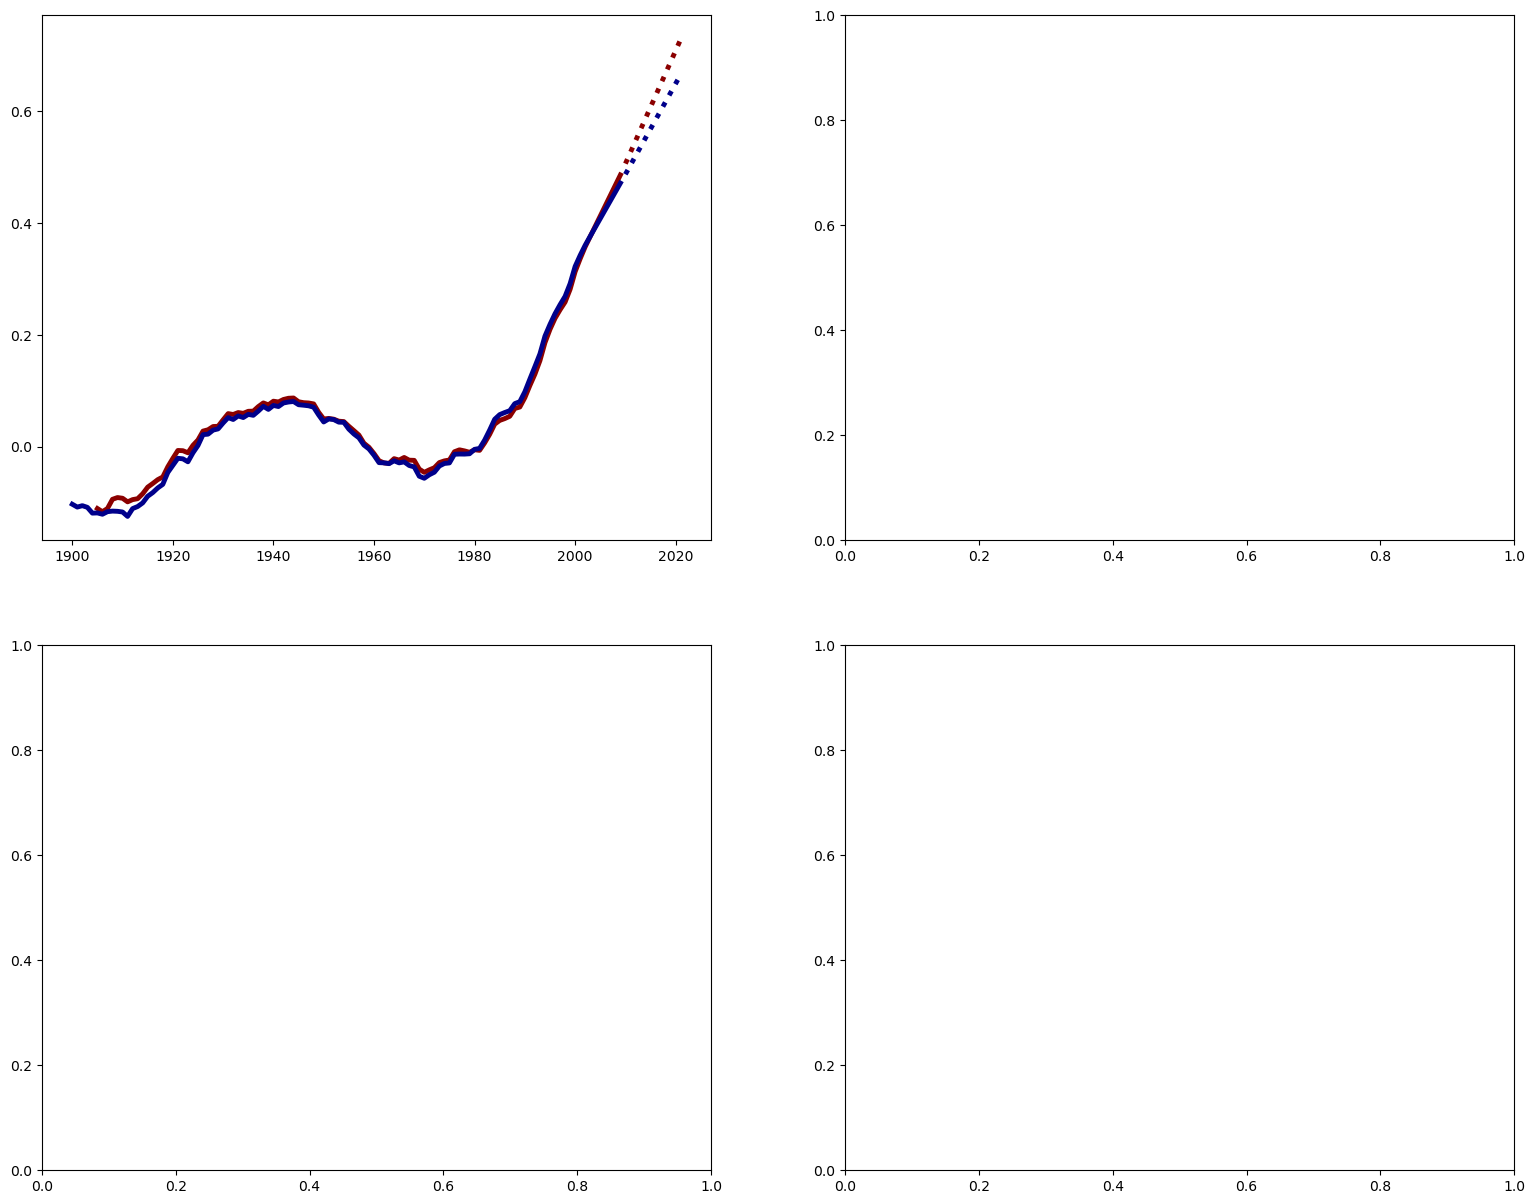

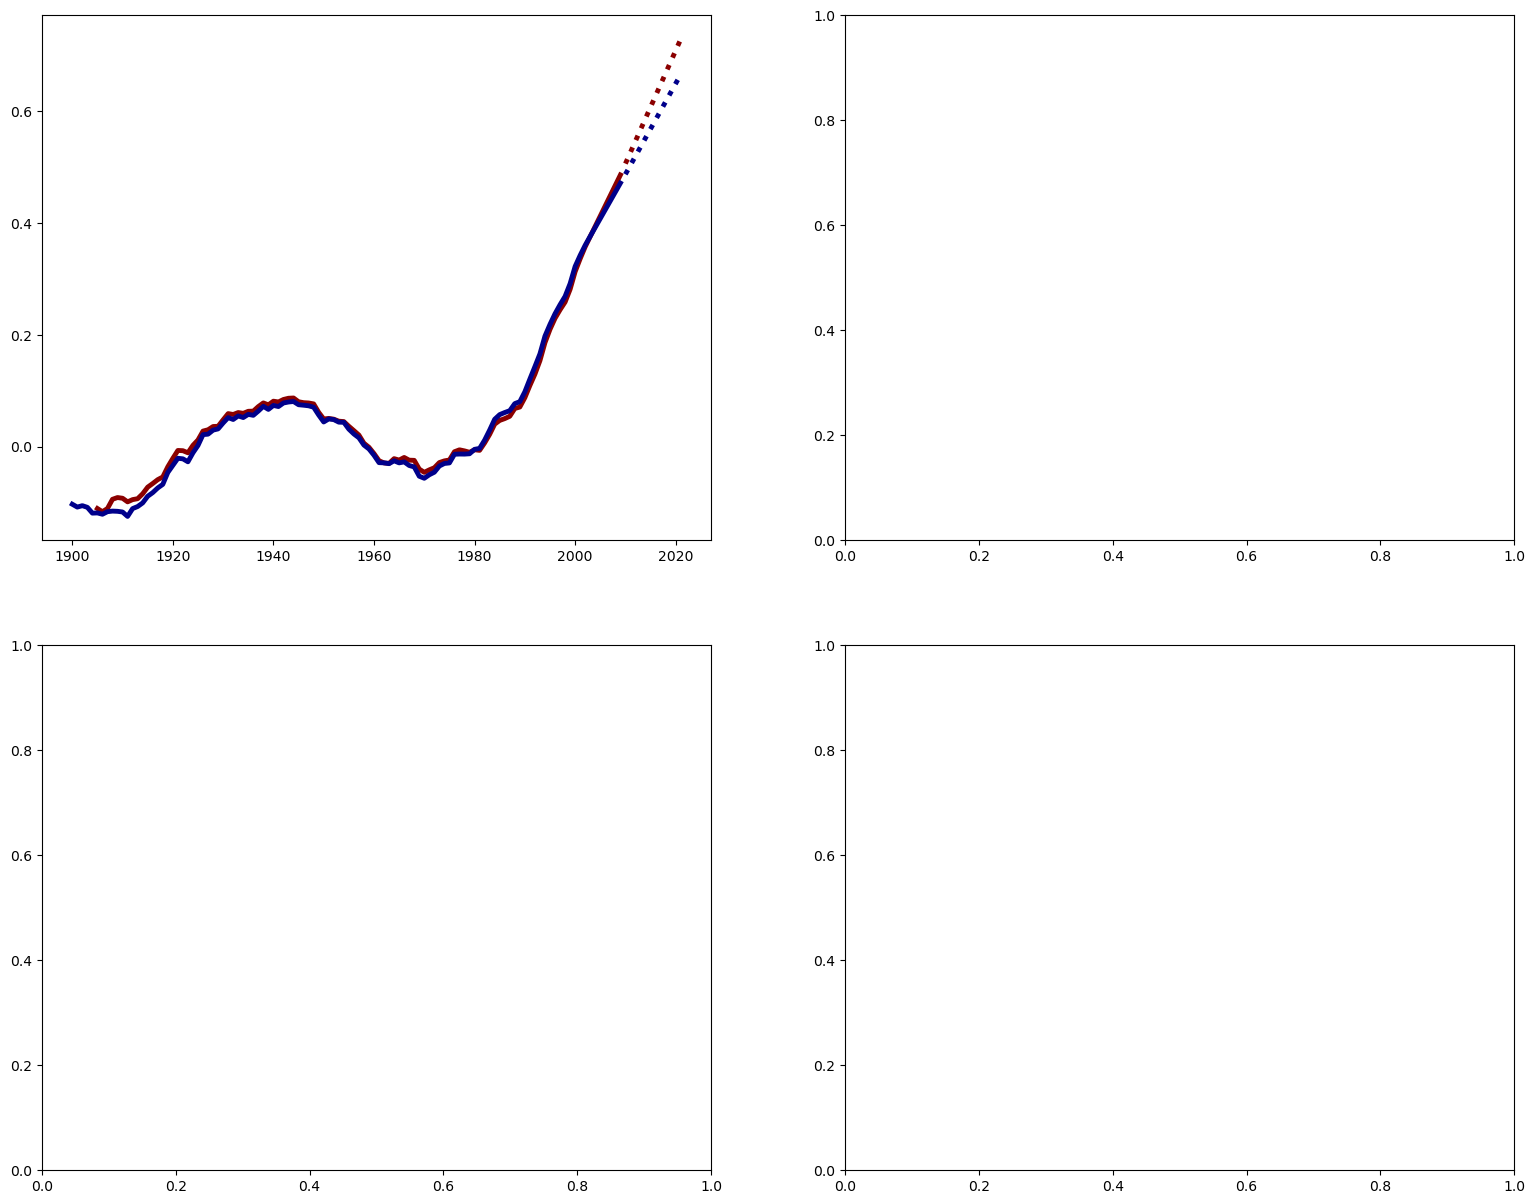

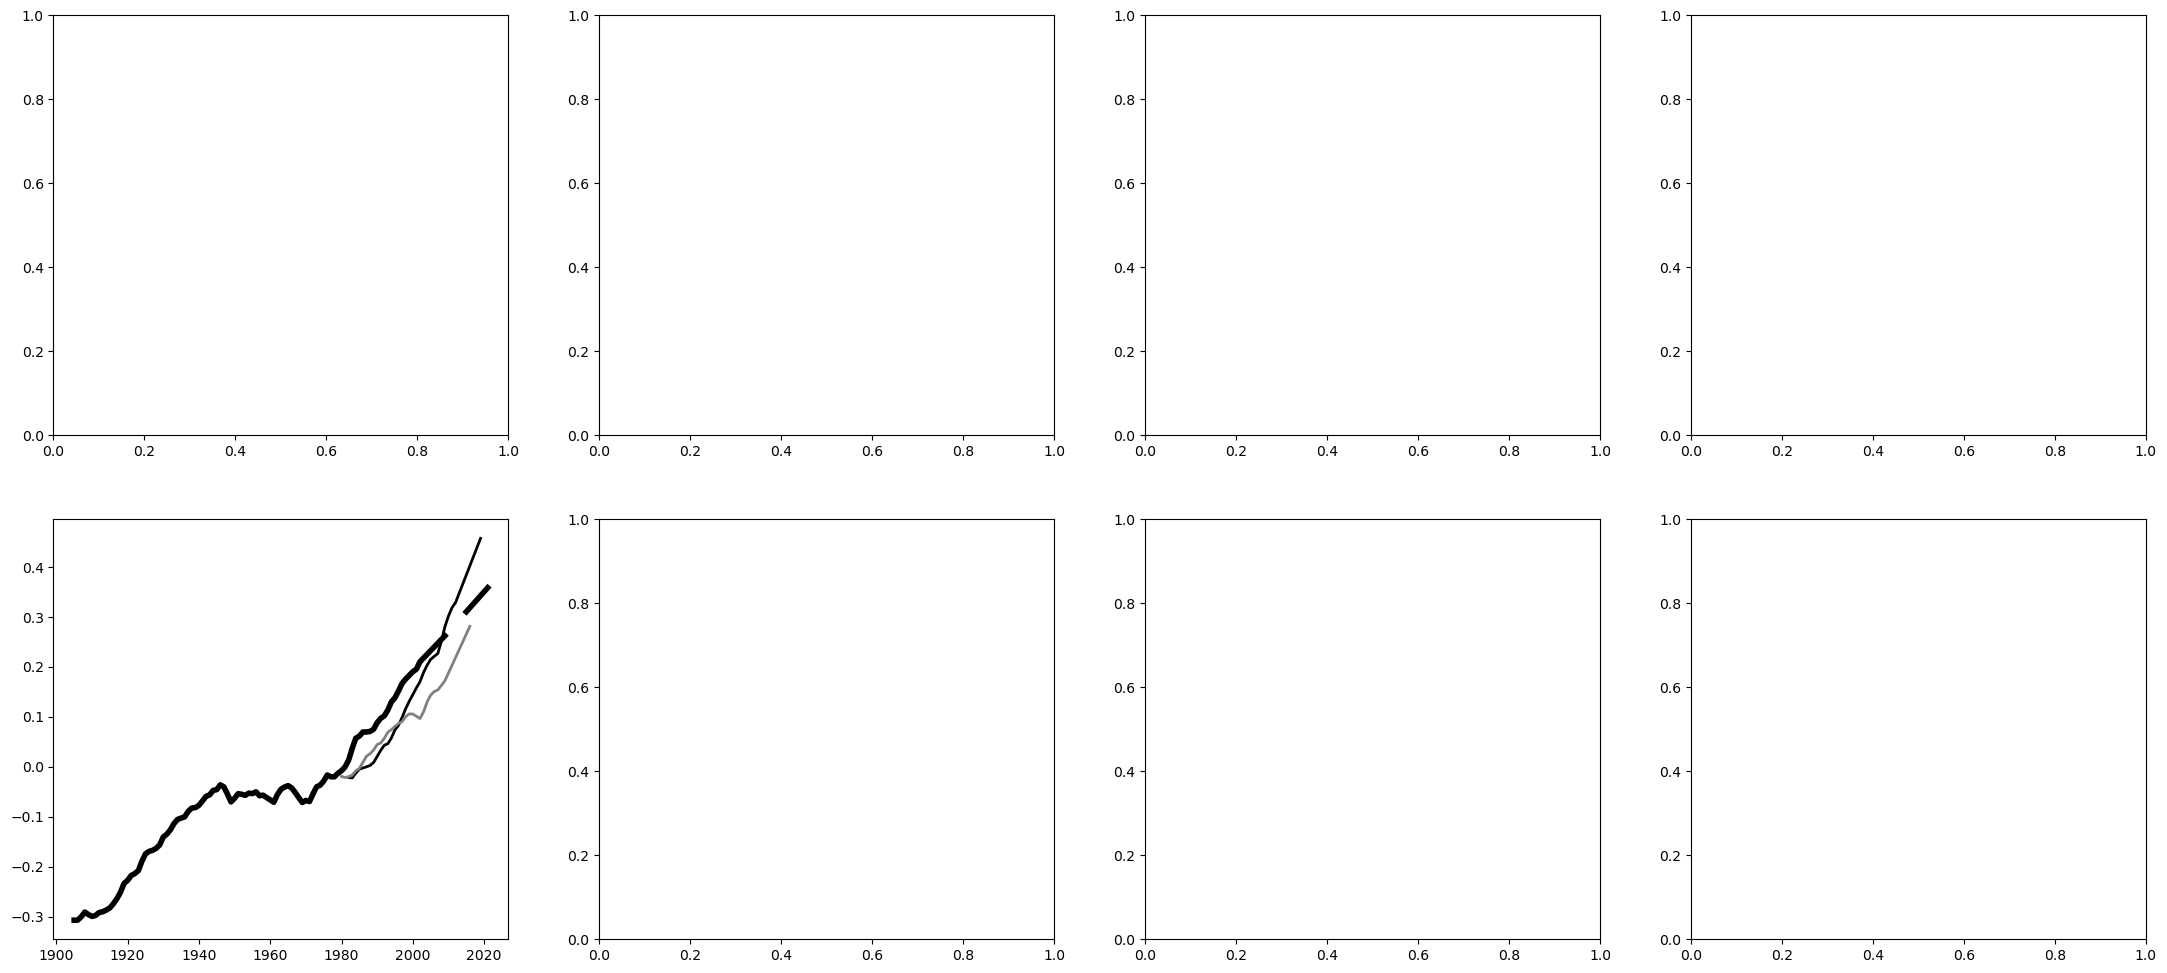

In [18]:
cwd=''

fig, ax =  plt.subplots(2,2,figsize=(19,15))
tos_shelves = []
table_names = []
var_runmean = []
runmean_len=10
shelves = ["shelf_400_TP04.nc","shelf400m_icon_cl"] #,"openocean_400_TP04.nc"]
linestyle = ["-"]
colors=["lightskyblue","darkkhaki","darkred"]
count=0

count_hamocc=0
count_icon=0
for shelf in shelves:
    print(shelf)
    #model sst
    if shelf == "shelf_400_TP04.nc":
        file_name = "analysis/T_spatial/" + shelf + "_T_riv_sum"+".nc"
        var,time = read_nc_var(cwd,file_name,"depto")
        var_plot=extrapolated_runmean(np.squeeze(var[:]),runmean_len)    
        years=np.arange(1905,1905+len(var_plot))
        var_plot=extrapolate_until_2000(var_plot,1905,years)
        years_plot=np.arange(1905,1905+len(var_plot))
        ax[0,0].plot(years_plot[0:105],var_plot[0:105]-np.mean(np.squeeze(var_plot[70:80])),color="darkred",linewidth=3.5,linestyle=linestyle[count_hamocc])
        ax[0,0].plot(years_plot[105::],var_plot[105::]-np.mean(np.squeeze(var_plot[70:80])),color="darkred",linewidth=3.5,linestyle="dotted")
        var_runmean_trend,a = np.polyfit(years_plot[75:-2], var_plot[75:-2], 1)
        print("1975-1980 average SST HAMOCC = ",np.mean(var_plot[70:80]))
        trend,a = np.polyfit(np.arange(0,len(time[75::])),np.squeeze(var[75::]),1)
        count_hamocc = count_hamocc + 1
    else:
        file_name = "analysis/T/" + shelf + "_T"+".nc"
        var,time = read_nc_var(cwd,file_name,"to")
        var_plot_icon=extrapolated_runmean(np.squeeze(var[:]),runmean_len)
        years=np.arange(1900,1900+len(var_plot_icon))
        var_plot_icon=extrapolate_until_2000(var_plot_icon,1900,years)
        years_plot_icon=np.arange(1900,1900+len(var_plot_icon))
        ax[0,0].plot(years_plot_icon[0:110],var_plot_icon[0:110]-np.mean(np.squeeze(var_plot_icon[75:85])),color="darkblue",linewidth=3.5,linestyle=linestyle[count_icon])
        ax[0,0].plot(years_plot_icon[110::],var_plot_icon[110::]-np.mean(np.squeeze(var_plot_icon[75:85])),color="darkblue",linewidth=3.5,linestyle="dotted")
        var_runmean_trend,a = np.polyfit(years_plot_icon[80:-2], var_plot_icon[80:-2], 1)
        print("1975-1980 average SST ICON = ",np.mean(var_plot_icon[75:85]))
        count_icon = count_icon + 1

    
fig.savefig("figures/Global_coastal_TS_rel1980s.png",dpi=500)
    
    
fig2, ax2 =  plt.subplots(2,4,figsize=(27,12))    
####### open ocean #######    
#plot observations
#observation sst
file_name = "analysis/observations/sst.an.mean_400openocean_fldmean.nc"
var,time = read_nc_var(cwd,file_name,"sst")
var_np = np.squeeze(np.array(var[0:38]))
var_runmean = extrapolated_runmean(var_np,10)
years = np.arange(1982,1982+len(var_runmean))
var_runmean_trend,a = np.polyfit(years, var_runmean, 1)
print("trend sst open ocean NOAA=",var_runmean_trend*(len(np.arange(1980,2020))))
var_sst_NOAA = np.zeros(117)
var_sst_NOAA[-len(var_runmean):] = var_runmean-np.mean(np.squeeze(var_runmean[1:10]))
ax2[1,0].plot(years,(np.squeeze(var_runmean)-np.mean(np.squeeze(var_runmean[0:10]))),color="black",linewidth=2)
print("1975-1980 averageopen ocean SS NOAA = ",np.mean(var_np[0:10])-6*var_runmean_trend)

#plot observations
#observation sst
file_name = "analysis/observations/HadISST_sst_annual_0p25res_400mopenocean_fldmean.nc"
var,time = read_nc_var(cwd,file_name,"sst")
var_np = np.squeeze(np.array(var[114:-2]))
var_runmean = extrapolated_runmean(var_np,10)
years = np.arange(1980,1980+len(var_runmean))
var_runmean_trend,a = np.polyfit(years, var_runmean, 1)
print("trend sst open ocean hadISST=",var_runmean_trend*(len(np.arange(1980,2020))))
var_sst_hadisst = np.zeros(117)
var_sst_hadisst[-len(var_runmean):] = var_runmean-np.mean(np.squeeze(var_runmean[1:10]))
ax2[1,0].plot(years,(np.squeeze(var_runmean)-np.mean(np.squeeze(var_runmean[0:10]))),color="grey",linewidth=2)
print("1975-1980 average open ocean SST HadISST= ",np.mean(var_np[0:10])-6*var_runmean_trend)

shelves = ["openocean_400_TP04.nc","openocean400m_icon_cl"]
count=0
for shelf in shelves:
    if shelf == "openocean_400_TP04.nc":
        #model sst
        file_name = "analysis/T_spatial/" + shelf + "_T"+"_riv_sum.nc"
        var,time = read_nc_var(cwd,file_name,"depto")
        var_plot=extrapolated_runmean(np.squeeze(var[:]),runmean_len)
        years=np.arange(1905,1905+len(var_plot))
        var_plot=extrapolate_until_2000(var_plot,1905,years)
        years_plot=np.arange(1905,1905+len(var_plot))
        ax2[1,0].plot(years_plot[0:105],var_plot[0:105]-np.mean(np.squeeze(var_plot[70:80])),color="black",linewidth=4,linestyle=linestyle[count])
        ax2[1,0].plot(years_plot[110::],var_plot[110::]-np.mean(np.squeeze(var_plot[70:80])),color="black",linewidth=4,linestyle=linestyle[count])
        print("1975-1985 average SST HAMOCC = ",np.mean(var_plot[70:80]))
        table_names = np.append(table_names,"{}".format(shelf))
        count=count+1    
    else:
        file_name = "analysis/T/" + shelf + "_T"+".nc"
        var,time = read_nc_var(cwd,file_name,"to")
        var_plot_icon=extrapolated_runmean(np.squeeze(var[:]),runmean_len)
        years=np.arange(1900,1900+len(var_plot_icon))
        var_plot_icon=extrapolate_until_2000(var_plot_icon,1900,years)
        years_plot_icon=np.arange(1900,1900+len(var_plot_icon))
        #ax[0,0].plot(years_plot_icon,var_plot_icon-np.mean(np.squeeze(var_plot_icon[75:85])),color="black",linewidth=2.5)
        print("1975-1985 average SST ICON = ",np.mean(var_plot_icon[75:85]))
    count=count+1

    
#### Trends open ocean
print("trend sst model open ocean=",trend*35)
trend,a = np.polyfit(np.arange(0,len(time[0:75])),np.squeeze(var[0:75]),1)
print("trend sst model open ocean 1900-1980=",trend*len(var[0:75]))
var_sst_hamocc = np.zeros(2022-1905)
var_sst_hamocc[-len(var_plot):] = (var_plot-np.mean(np.squeeze(var_plot[70:80])))
var_runmean_trend,a = np.polyfit(years_plot[75:-2], var_sst_hamocc[75:-2], 1)
print("trend sst open ocean HAMOCC=",var_runmean_trend*(len(np.arange(1980,2020))))

var_sst_icon = np.zeros(2022-1905)
var_sst_icon[-len(var_plot_icon):] = (var_plot_icon[5::]-np.mean(np.squeeze(var_plot_icon[75:85])))
var_runmean_trend,a = np.polyfit(years_plot[75:-2], var_sst_icon[75:-2], 1)
print("trend sst open ocean ICON=",var_runmean_trend*(len(np.arange(1980,2020))))


    
fig2.savefig("figures/Global_openocean_TS_rel1980s_attribution.png",dpi=500)
fig

trend h+ HAMOCC riv= 1.255566133810353e-09
1975-1985 coastal average H+ HAMOCC =  9.117826831328556e-09
trend h+ HAMOCC clim= 1.2347698462039423e-09
1975-1985 coastal average H+ HAMOCC =  9.118641693580305e-09
trend h+ HAMOCC CO2= 1.3701039504399055e-09
1975-1985 coastal average H+ HAMOCC =  9.05005967055672e-09
trend h+ icon co2_clim= 1.2961502289694044e-09
1975-1985 coastal average H+ ICON =  8.028814342253554e-09
trend h+ icon all= 1.2857116302950674e-09
1975-1985 coastal average H+ ICON =  8.00457548540597e-09
trend h+ open ocean HAMOCC CO2= 7.429494374981019e-10
1975-1985 coastal average H+ HAMOCC =  1.3513075689530751e-08
trend h+ open ocean HAMOCC clim= 7.772290486837754e-10
1975-1985 coastal average H+ HAMOCC =  1.3530224715433784e-08
trend h+ open ocean HAMOCC riv= 7.911612321322689e-10
1975-1985 coastal average H+ HAMOCC =  1.3538187163912124e-08
trend h+ open ocean icon CO2= 1.2261760123158706e-09
1975-1985 average H+ ICON =  7.763927255174015e-09
trend h+ open ocean icon cl

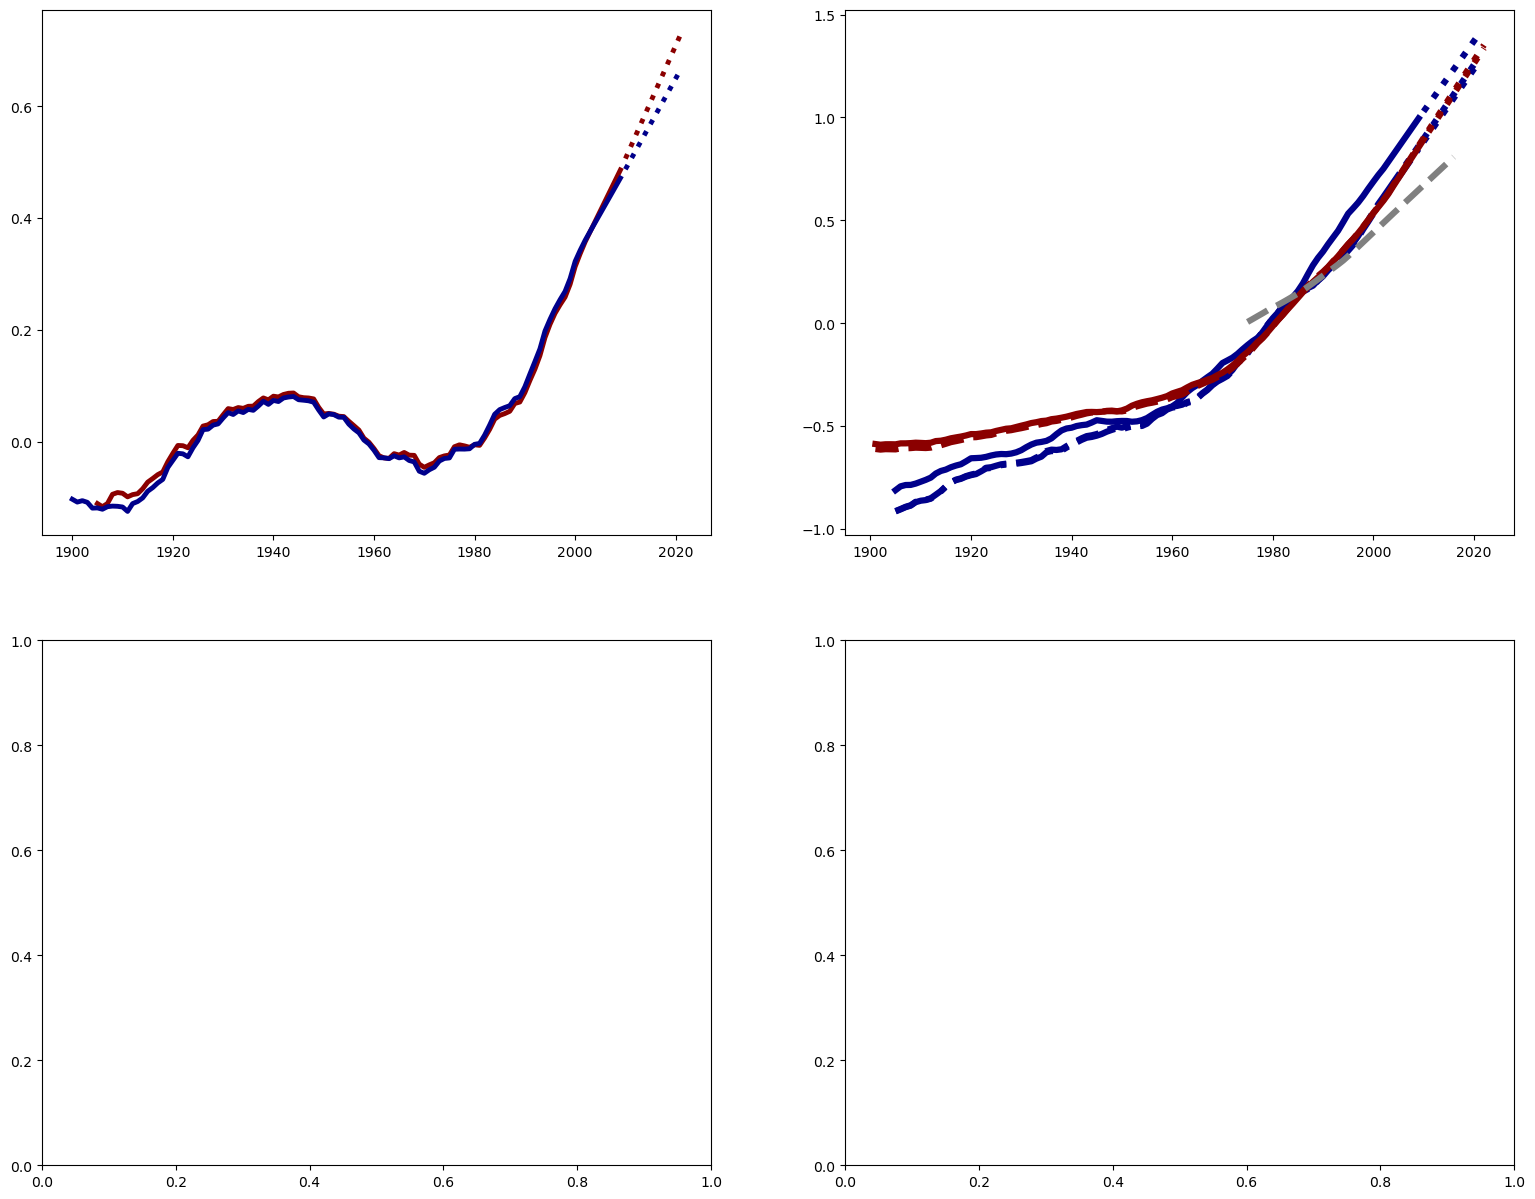

In [19]:
linestyle = ["-.","dashed","-"]
shelves=["shelf_250_TP04.nc","shelf400m_icon_cl"]
count = 0
for shelf in shelves:
    count_hamocc=0
    count_icon=0
    if shelf=="shelf_250_TP04.nc":        
        #pH
        for sim in ["riv","clim","CO2"]:
        #for sim in ["riv"]:
            file_name = "analysis/pH/" + shelf + "_hi_"+ sim + "_mean" + ".nc"
            var,time = read_nc_var(cwd,file_name,"depto")
            var_plot=extrapolated_runmean(np.squeeze(var[:]),runmean_len)      
            years=np.arange(1905,1905+len(var_plot))
            var_plot=extrapolate_until_2000(var_plot,1905,years)
            years_plot=np.arange(1905,1905+len(var_plot[0:117]))
            var_runmean_trend,a = np.polyfit(years_plot[75:-2], var_plot[75:-2], 1)
            print("trend h+ HAMOCC {}=".format(sim),var_runmean_trend*(len(np.arange(1980,2020))))
            print("1975-1985 coastal average H+ HAMOCC = ",np.mean(var_plot[70:80]))
            ax[0,1].plot(years_plot[0:105],(var_plot[0:105]-np.mean(np.squeeze(var_plot[70:80])))*1E9,color="darkblue",linewidth=4.5, linestyle=linestyle[count_hamocc])
            ax[0,1].plot(years_plot[105::],(var_plot[105::]-np.mean(np.squeeze(var_plot[70:80])))*1E9,color="darkblue",linewidth=4.5,linestyle="dotted")
            count_hamocc=count_hamocc+1
    linestyle = ["dashed","-"]
    if shelf=="shelf400m_icon_cl":
        for sim in ["co2_clim","all"]:
        #for sim in ["all"]:
            file_name = "analysis/pH/" + shelf + "_hi_"+ sim + "_mean" + ".nc"
            var,time = read_nc_var(cwd,file_name,"hi")
            var_plot_icon=extrapolated_runmean(np.squeeze(var[:]),runmean_len)      
            years=np.arange(1901,1901+len(var_plot_icon))
            var_plot_icon=extrapolate_until_2000(var_plot_icon,1900,years)
            years_plot_icon=np.arange(1901,1901+len(var_plot_icon[:]))
            var_runmean_trend,a = np.polyfit(years_plot_icon[80:-2], var_plot_icon[80:-2], 1)
            print("trend h+ icon {}=".format(sim),var_runmean_trend*(len(np.arange(1980,2020))))
            print("1975-1985 coastal average H+ ICON = ",np.mean(var_plot_icon[75:85]))
            ax[0,1].plot(years_plot_icon[0:110],(var_plot_icon[0:110]-np.mean(np.squeeze(var_plot_icon[75:85])))*1E9,color="darkred",linewidth=4.5,linestyle=linestyle[count_icon])
            ax[0,1].plot(years_plot_icon[110::],(var_plot_icon[110::]-np.mean(np.squeeze(var_plot_icon[75:85])))*1E9,color="darkred",linewidth=4.5,linestyle="dotted")
            count_icon=count_icon+1


shelves=["openocean_400_TP04.nc","openocean400m_icon_cl"]
count = 0
for shelf in shelves:
    for sim in ["CO2","clim","riv"]:
        if shelf=="openocean_400_TP04.nc":
            #ph
            file_name = "analysis/pH/" + shelf + "_hi_"+ sim + "_mean" + ".nc"
            var,time = read_nc_var(cwd,file_name,"depto")
            var_plot=extrapolated_runmean(np.squeeze(var[:]),runmean_len)      
            years=np.arange(1905,1905+len(var))
            var_plot=extrapolate_until_2000(var_plot,1905,years)
            years_plot=np.arange(1900,1900+len(var_plot[:]))                        
            var_runmean_trend,a = np.polyfit(years_plot[75:-2], var_plot[75:-2], 1)
            print("trend h+ open ocean HAMOCC {}=".format(sim),var_runmean_trend*(len(np.arange(1980,2020))))
            print("1975-1985 coastal average H+ HAMOCC = ",np.mean(var_plot[70:80]))
            #ax2[1,1].plot(years_plot,(var_plot-np.mean(np.squeeze(var[75:85])))*1E9,color=colors[count],linewidth=4)
            count=count+1
        
        if shelf=="openocean400m_icon_cl":
            file_name = "analysis/pH/" + shelf + "_hi_"+ "all" + "_mean" + ".nc"
            var,time = read_nc_var(cwd,file_name,"hi")
            var_plot_icon=extrapolated_runmean(np.squeeze(var[:]),runmean_len)      
            years=np.arange(1900,1900+len(var_plot_icon))
            var_plot_icon=extrapolate_until_2000(var_plot_icon,1900,years)
            years_plot_icon=np.arange(1900,1900+len(var_plot_icon[:]))
            var_runmean_trend,a = np.polyfit(years_plot_icon[80:-2], var_plot_icon[80:-2], 1)
            print("trend h+ open ocean icon {}=".format(sim),var_runmean_trend*(len(np.arange(1980,2020))))
            print("1975-1985 average H+ ICON = ",np.mean(var_plot_icon[75:85]))
            #ax[0,1].plot(years_plot_icon,(var_plot_icon[:]-np.mean(np.squeeze(var[75:85])))*1E9,color="black",linewidth=3.5)
            count=count+1

print("h+ trend coastal",np.polyfit(years_plot[75::],var_plot[75::],1)[0]*len(years_plot[70::]))

### Put together model variables for averages/mins/maxs           
var_ph_hamocc = np.zeros(117)
var_ph_hamocc[-len(var_plot[0:117]):] = (var_plot[:]-np.mean(np.squeeze(var_plot[70:80])))*1E9
var_ph_icon = np.zeros(117)
var_ph_icon[-len(var_plot[0:117]):] = (var_plot_icon[4:-1]-np.mean(np.squeeze(var_plot_icon[75:85])))*1E9



#var_ph_mean = np.mean(var_concat_obs,axis=0)
ax[0,1].plot(years_plot[75::],var_ph_hamocc[75::],color="grey",linewidth=4.5,linestyle="dashed")
fig


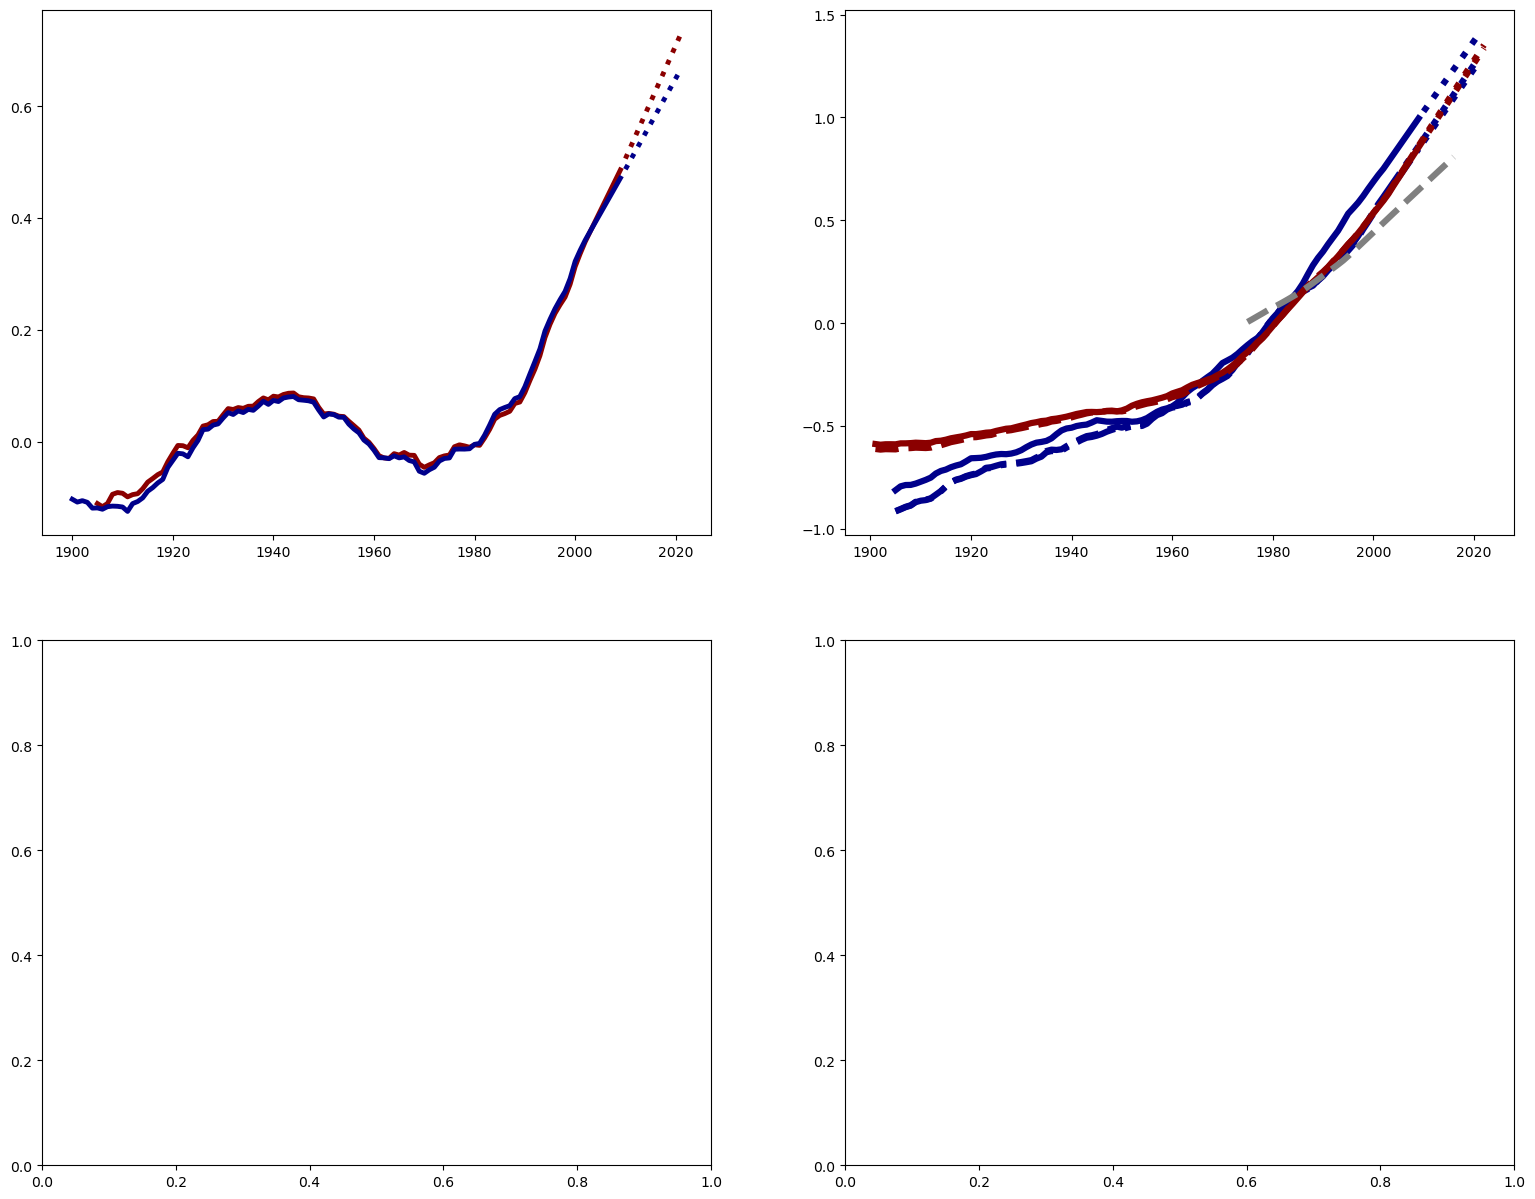

In [20]:
fig

In [21]:
colors=["darkkhaki","darkred"]
linestyle = ["dashed","-"]
shelves=["shelf_400_TP04.nc","shelf400m_icon_cl"]
count = 0
for shelf in shelves:
    count_hamocc=0
    count_icon=0
    if shelf=="shelf_400_TP04.nc":        
        #pH
        for sim in ["clim","riv"]:
        #for sim in ["riv"]:
            file_name = "analysis/NPP/" + shelf + "_NPP_"+ sim + "_mean" + ".nc"
            var,time = read_nc_var(cwd,file_name,"depto")
            var_plot=extrapolated_runmean(np.squeeze(var[:]),runmean_len)   
            years=np.arange(1905,1905+len(var_plot))
            var_plot=extrapolate_until_2000(var_plot,1905,years)
            var_plot=var_plot 
            years_plot=np.arange(1905,1905+len(var_plot[:]))
            ax[1,0].plot(years_plot[:105],(var_plot[:105] - np.mean(var_plot[70:80])),color="darkblue",linewidth=4.5,linestyle=linestyle[count_hamocc])
            ax[1,0].plot(years_plot[105:-2],(var_plot[105:-2] - np.mean(var_plot[70:80])),color="darkblue",linewidth=4.5,linestyle="dotted")
            var_runmean_trend,a = np.polyfit(years_plot[75:-2], var_plot[75:-2], 1)
            print("trend NPP coastal HAMOCC {}=".format(sim),var_runmean_trend*(len(np.arange(1980,2020)))*1E-15)
            print("1975-1985 coastal average NPP HAMOCC = ",np.mean(var_plot[70:80]))            
            sim_prev=sim
            count_hamocc=count_hamocc+1
    if shelf=="shelf400m_icon_cl":
        for sim in ["co2_clim","all"]:
        #for sim in ["all"]:
            file_name = "analysis/NPP/" + shelf + "_NPP_"+ sim + "_perm2_mean" + ".nc"
            var,time = read_nc_var(cwd,file_name,"NPP")
            var_plot_icon=extrapolated_runmean(np.squeeze(var[:]),runmean_len)   
            years=np.arange(1900,1900+len(var_plot_icon))
            var_plot_icon=extrapolate_until_2000(var_plot_icon,1900,years)
            var_plot_icon=var_plot_icon
            years_plot_icon=np.arange(1900,1900+len(var_plot_icon[0::]))
            ax[1,0].plot(years_plot_icon[0:110],(var_plot_icon[0:110] - np.mean(var_plot_icon[75:85])),color="darkred",linewidth=4.5,linestyle=linestyle[count_icon])
            ax[1,0].plot(years_plot_icon[110:-2],(var_plot_icon[110:-2] - np.mean(var_plot_icon[75:85])),color="darkred",linewidth=4.5,linestyle="dotted")
            var_runmean_trend,a = np.polyfit(years_plot_icon[80:-2], var_plot_icon[80:-2], 1)
            print("trend NPP coastal ICON {}=".format(sim),var_runmean_trend*(len(np.arange(1980,2020))))
            print("1975-1985 coastal average H+ ICON = ",np.mean(var_plot_icon[75:85]*1E-15))
            count_icon=count_icon+1
            
#observation NPP
file_name = "analysis/observations/vgpm_wgrid_annual_all_0p25res_400mopenocean_fldsum.nc"
var,time = read_nc_var(cwd,file_name,"npp")
var = np.average(var[:].reshape(-1, 19), axis=0)
var_runmean =extrapolated_runmean(var,5)
years = np.arange(2002,2002+len(var))


shelves=["openocean_400_TP04.nc"]
count = 0
for shelf in shelves:
    for sim in ["clim","riv"]:
        #NPP
        file_name = "analysis/NPP/" + shelf + "_NPP_"+ sim + "_sum" + ".nc"
        var,time = read_nc_var(cwd,file_name,"NPP")
        print(np.shape(var))
        var_plot=extrapolated_runmean(np.squeeze(var[:]),runmean_len) 
        years=np.arange(1905,1905+len(var_plot))
        var_plot=extrapolate_until_2000(var_plot,1905,years)
        var_plot = var_plot / (650 * 1E12)
        years_plot=np.arange(1905,1905+len(var_plot))
        #ax2[1,0].plot(years_plot,(var_plot[0:115] - np.mean(var_plot[60:75]))*1E-15,color=colors[count],linewidth=4)
        var_runmean_trend,a = np.polyfit(years_plot[75::], var_plot[75::], 1)
        print("trend NPP open ocean HAMOCC {}=".format(sim),var_runmean_trend*(len(np.arange(1980,2020))))
        print("1975-1985 open ocean average NPP HAMOCC = ",(np.mean(var_plot[70:80])))
        sim_prev=sim
        count=count+1
        
### Model NPP
var_npp_hamocc = np.zeros(117)
var_npp_hamocc[-117::] = (var_plot[0:117] - np.mean(var_plot[70:80]))
ax[1,0].plot(years_plot[75::],var_npp_hamocc[75::],color="grey",linewidth=4.5,linestyle="dashed")

trend NPP coastal HAMOCC clim= 5.3309370168893995e-15
1975-1985 coastal average NPP HAMOCC =  115.48663736979168
trend NPP coastal HAMOCC riv= 1.1777382595902569e-14
1975-1985 coastal average NPP HAMOCC =  124.46995630900065
trend NPP coastal ICON co2_clim= 8.12897526008355
1975-1985 coastal average H+ ICON =  1.499063386027018e-13
trend NPP coastal ICON all= 16.77034112330721
1975-1985 coastal average H+ ICON =  1.6225124186197919e-13
(105, 1, 1)
trend NPP open ocean HAMOCC clim= 5.246638931197488
1975-1985 open ocean average NPP HAMOCC =  67.60252555870964
(105, 1, 1)
trend NPP open ocean HAMOCC riv= 5.246638931197488
1975-1985 open ocean average NPP HAMOCC =  67.60252555870964


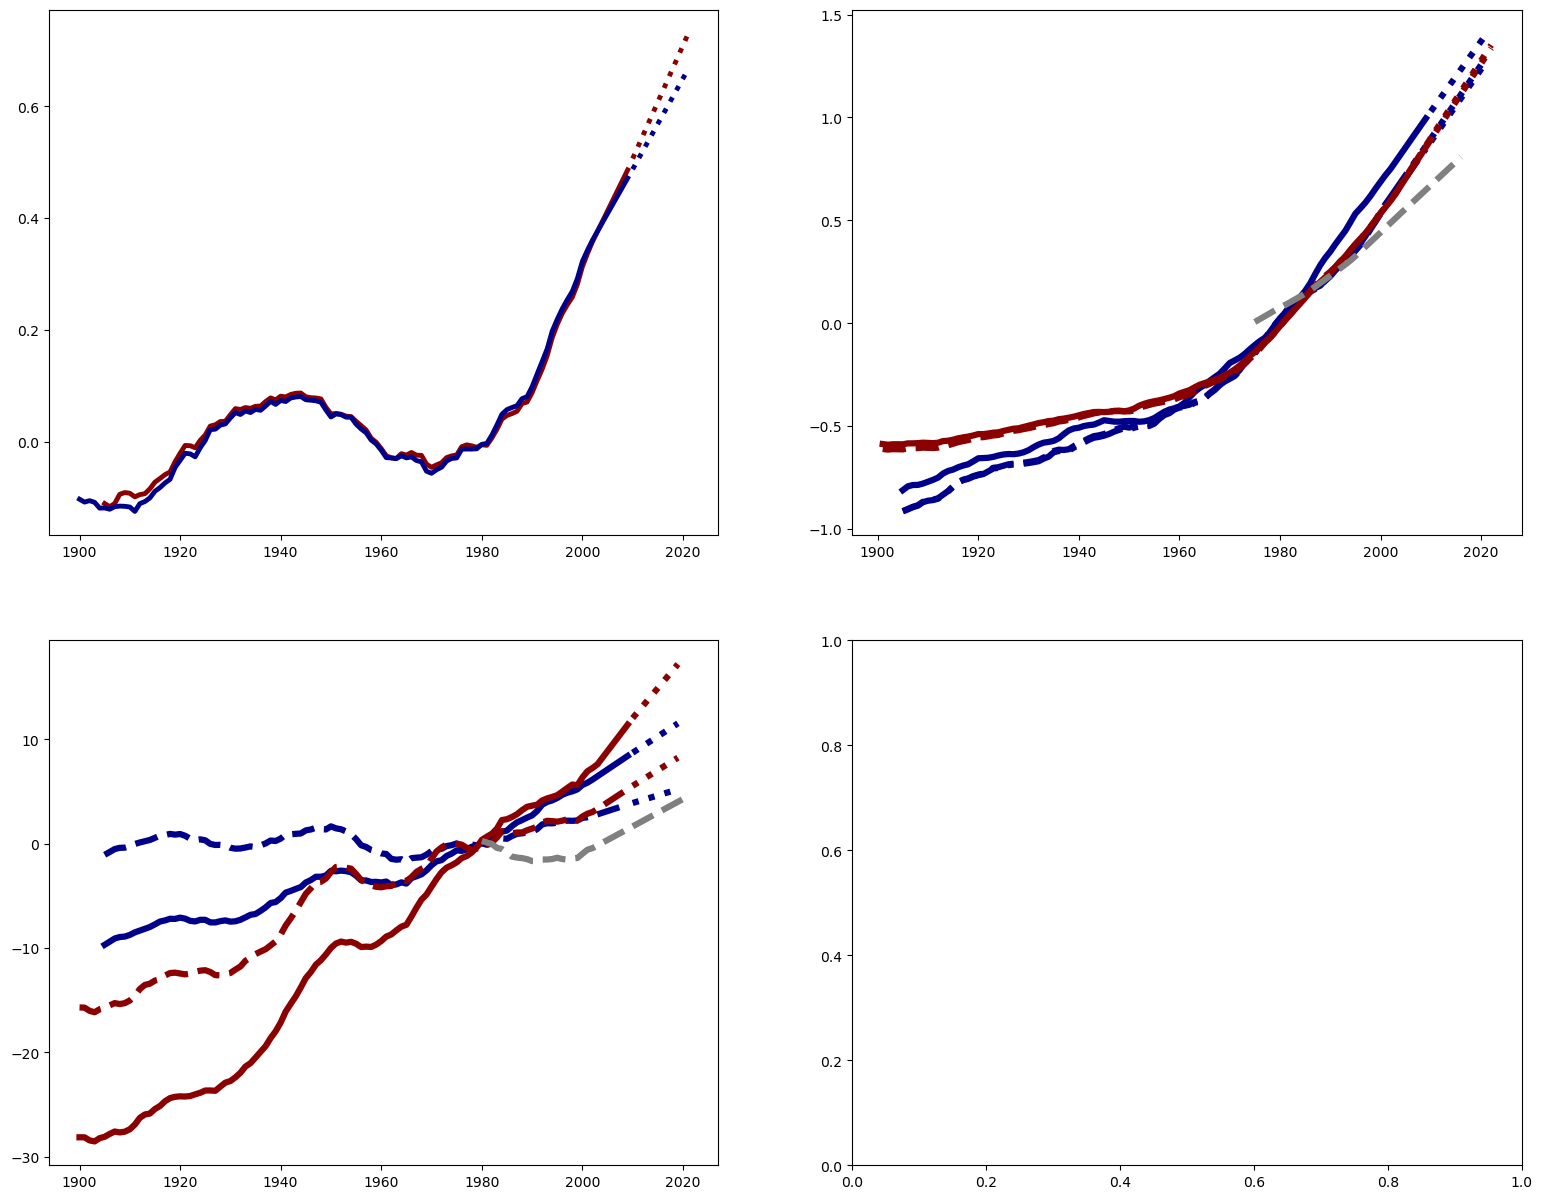

In [22]:
fig

In [23]:
shelves=["shelf_400_TP04.nc","shelf400m_icon_cl"]
count=0
for shelf in shelves:
    count_hamocc=0
    count_icon=0
    if shelf=="shelf_400_TP04.nc":        
        #pH
        #for sim in ["clim","riv"]:
        for sim in ["riv","clim"]:
            #Oxygen
            file_name = "analysis/oxygen/" + shelf + "_oxygen_"+ sim + "_mean" + ".nc"
            var,time = read_nc_var(cwd,file_name,"depto")
            var_plot=extrapolated_runmean(np.squeeze(var[:]),runmean_len)
            years=np.arange(1905,1905+len(var_plot))
            var_plot=extrapolate_until_2000(var_plot,1905,years)
            years_plot=np.arange(1905,1905+len(var_plot[:]))
            ax[1,1].plot(years_plot[0:105],var_plot[0:105]-np.mean(np.squeeze(var_plot[70:80])),color="darkblue",linewidth=4.5,linestyle=linestyle[count_hamocc])
            ax[1,1].plot(years_plot[105:-2],var_plot[105:-2]-np.mean(np.squeeze(var_plot[70:80])),color="darkblue",linewidth=4.5)
            var_runmean_trend,a = np.polyfit(years_plot[75::], var_plot[75::], 1)
            print("trend O2 coastal HAMOCC {}=".format(sim),var_runmean_trend*(len(np.arange(1980,2020))))
            print("1975-1985 coastal average O2 HAMOCC = ",np.mean(var_plot[70:80])*32)
            count_hamocc=count_hamocc+1
    if shelf=="shelf400m_icon_cl":
        #for sim in ["co2_clim","all"]:
        for sim in ["co2_clim","all"]:
            file_name = "analysis/oxygen/" + shelf + "_oxygen_"+ sim + "_mean" + ".nc"
            var,time = read_nc_var(cwd,file_name,"o2")
            var_plot_icon=extrapolated_runmean(np.squeeze(var[:]),runmean_len)
            years_icon=np.arange(1900,1900+len(var_plot_icon))
            var_plot_icon=extrapolate_until_2000(var_plot_icon,1900,years_icon)
            years_plot_icon=np.arange(1900,1900+len(var_plot_icon[:]))
            ax[1,1].plot(years_plot_icon[0:105],var_plot_icon[0:105]-np.mean(np.squeeze(var_plot_icon[75:85])),color="darkred",linewidth=4.5,linestyle=linestyle[count_icon])
            ax[1,1].plot(years_plot_icon[105:-2],var_plot_icon[105:-2]-np.mean(np.squeeze(var_plot_icon[75:85])),color="darkred",linewidth=4.5)
            var_runmean_trend,a = np.polyfit(years_plot_icon[75::], var_plot_icon[75::], 1)
            print("trend O2 coastal ICON {}=".format(sim),var_runmean_trend*(len(np.arange(1980,2020))))
            print("1975-1985 coastal average O2 ICON = ",np.mean(var_plot_icon[75:85])*32)
            count_icon=count_icon+1

shelves=["openocean_400_TP04.nc","openocean400m_icon_cl"]
count=0
for shelf in shelves:
    for sim in ["clim","riv"]:
        if shelf=="openocean_400_TP04.nc":
            # Oxygen
            file_name = "analysis/oxygen/" + shelf + "_oxygen_"+ sim + "_mean" + ".nc"
            var,time = read_nc_var(cwd,file_name,"depto")
            var_plot=extrapolated_runmean(np.squeeze(var[:]-np.mean(var[70:80])),runmean_len)
            years=np.arange(1905,1905+len(var_plot))
            var_plot=extrapolate_until_2000(var_plot,1905,years)
            years_plot=np.arange(1905,1905+len(var_plot[:]))
            var_runmean_trend,a = np.polyfit(years_plot[75:-2], var_plot[75:-2], 1)
            print("trend O2 open ocean HAMOCC {}=".format(sim),var_runmean_trend*(len(np.arange(1980,2020))))
            print("1975-1985 open ocean average O2 HAMOCC = ",np.mean(var_plot[70:80])*32)
            count=count+1
        else:
            file_name = "analysis/oxygen/" + shelf + "_oxygen_"+ "all" + "_mean" + ".nc"
            var,time = read_nc_var(cwd,file_name,"o2")
            var_plot_icon=extrapolated_runmean(np.squeeze(var[:]-np.mean(var[75:85])),runmean_len)
            years_icon=np.arange(1900,1900+len(var_plot_icon))
            var_plot_icon=extrapolate_until_2000(var_plot_icon,1900,years_icon)
            years_plot_icon=np.arange(1900,1900+len(var_plot_icon[:]))
            var_runmean_trend,a = np.polyfit(years_plot_icon[75:-2], var_plot_icon[75:-2], 1)
            print("trend O2 open ocean ICON {}=".format(sim),var_runmean_trend*(len(np.arange(1980,2020))))            
            print("1975-1985 open ocean average O2 ICON = ",np.mean(var_plot_icon[75:85])*32)            
            count=count+1


var_o2_hamocc = np.zeros(117)
var_o2_hamocc[:] = (var_plot[0::] - np.mean(var_plot[70:80]))
var_o2_icon = np.zeros(117)
var_o2_icon[:] = (var_plot_icon[5::] - np.mean(var_plot_icon[75:85]))

var_concat = [var_o2_icon,var_o2_hamocc]
var_o2_mean=np.mean(var_concat,axis=0)
print("O2 trend open ocean since 1980s",np.polyfit(years_plot[75::],var_o2_mean[75::],1)[0]*len(years_plot[75::]))
ax[1,1].plot(years_plot[75::],var_o2_mean[75::],color="grey",linewidth=4.5,linestyle="dashed")

trend O2 coastal HAMOCC riv= -0.032351826887209625
1975-1985 coastal average O2 HAMOCC =  288.9869840494792
trend O2 coastal HAMOCC clim= -0.03922843019363877
1975-1985 coastal average O2 HAMOCC =  288.71559041341146
trend O2 coastal ICON co2_clim= -0.08111588169019093
1975-1985 coastal average O2 ICON =  264.7822058105468
trend O2 coastal ICON all= -0.0848649034079539
1975-1985 coastal average O2 ICON =  264.5841739908854
trend O2 open ocean HAMOCC clim= -0.03603247173502181
1975-1985 open ocean average O2 HAMOCC =  0.0026440429687500074
trend O2 open ocean HAMOCC riv= -0.035720264253869885
1975-1985 open ocean average O2 HAMOCC =  0.0027758789062499955
trend O2 open ocean ICON clim= -0.04351631511722241
1975-1985 open ocean average O2 ICON =  0.06775543212890625
trend O2 open ocean ICON riv= -0.04351631511722241
1975-1985 open ocean average O2 ICON =  0.06775543212890625
O2 trend open ocean since 1980s -0.03990318046496148


In [24]:
ax[0,0].set_title("Coastal SST [°C]",fontsize=28,pad=14)
ax[0,0].legend(["ICON-COAST $ALL$","_nolegend_","HAMOCC-RIV $ALL$","_nolegend_","Open ocean mean"],fontsize=20)
ax[0,1].set_title("Coastal surface H$^{+}$ [M]",fontsize=28,pad=14)
ax[0,1].legend(["HAMOCC-RIV $CO2$-Only","_nolegend_","HAMOCC-RIV $CO2+CLIM$","_nolegend_","HAMOCC-RIV $ALL$","_nolegend_","ICON COAST $CO2+CLIM$","_nolegend_","ICON-COAST $ALL$","_nolegend_","Open ocean mean"],fontsize=20)
ax[1,0].set_title("Coastal NPP [Pg C yr$^{-1}$]",fontsize=28,pad=14)
ax[1,0].legend(["HAMOCC-RIV $CO2+CLIM$","_nolegend_","HAMOCC-RIV $ALL$","_nolegend_","ICON-COAST $CO2+CLIM$","_nolegend_","ICON-COAST $ALL$","_nolegend_","Open ocean mean"],fontsize=20)
ax[1,1].set_title("Coastal O$_{2}$ [mg O$_{2}$ ℓ$^{-1}$ yr$^{-1}$]",fontsize=28,pad=14)
ax[1,1].legend(["HAMOCC-RIV $CO2+CLIM$","_nolegend_","HAMOCC-RIV $ALL$","_nolegend_","ICON-COAST $CO2+CLIM$","_nolegend_","ICON-COAST $ALL$","_nolegend_","Open ocean mean"],fontsize=20)
fig.tight_layout() 

alphabet=list(string.ascii_lowercase)
count = 0
for axe in ax.reshape(-1):
    axe.tick_params(axis='both', which='major', labelsize=22)

    axe.minorticks_on()
    axe.tick_params('both', length=15, width=2, which='major')
    axe.tick_params('both', length=5, width=1, which='minor')

    title_pos =axe.title.get_position()
    axe.annotate("({})".format(alphabet[count]),
            xy=([title_pos[0]-0.68,title_pos[1]+0.05]), xytext=(0, 0.5), 
            xycoords=('axes fraction', 'axes fraction'),
            textcoords='offset points',size=28)
    count = count + 1
    
fig
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.2)
fig.savefig("figures/Global_coastal_TS_rel1980s_attribution.png",dpi=500,bbox_inches='tight',facecolor="white")

/var/folders/0y/spqmc12x7jl4vpd6l453_34c0000gp/T/ipykernel_2849/3187342732.py:2: UserWarning: The handle <matplotlib.lines.Line2D object at 0x134f089d0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  ax[0,0].legend(["ICON-COAST $ALL$","_nolegend_","HAMOCC-RIV $ALL$","_nolegend_","Open ocean mean"],fontsize=20)
/var/folders/0y/spqmc12x7jl4vpd6l453_34c0000gp/T/ipykernel_2849/3187342732.py:2: UserWarning: The handle <matplotlib.lines.Line2D object at 0x134e06070> has a label of '_nolegend_' which cannot be automatically added to the legend.
  ax[0,0].legend(["ICON-COAST $ALL$","_nolegend_","HAMOCC-RIV $ALL$","_nolegend_","Open ocean mean"],fontsize=20)
/var/folders/0y/spqmc12x7jl4vpd6l453_34c0000gp/T/ipykernel_2849/3187342732.py:4: UserWarning: The handle <matplotlib.lines.Line2D object at 0x134e4be50> has a label of '_nolegend_' which cannot be automatically added to the legend.
  ax[0,1].legend(["HAMOCC-RIV $CO2$-Only","_nolegend_","HAMOCC-RIV $CO2+CLIM

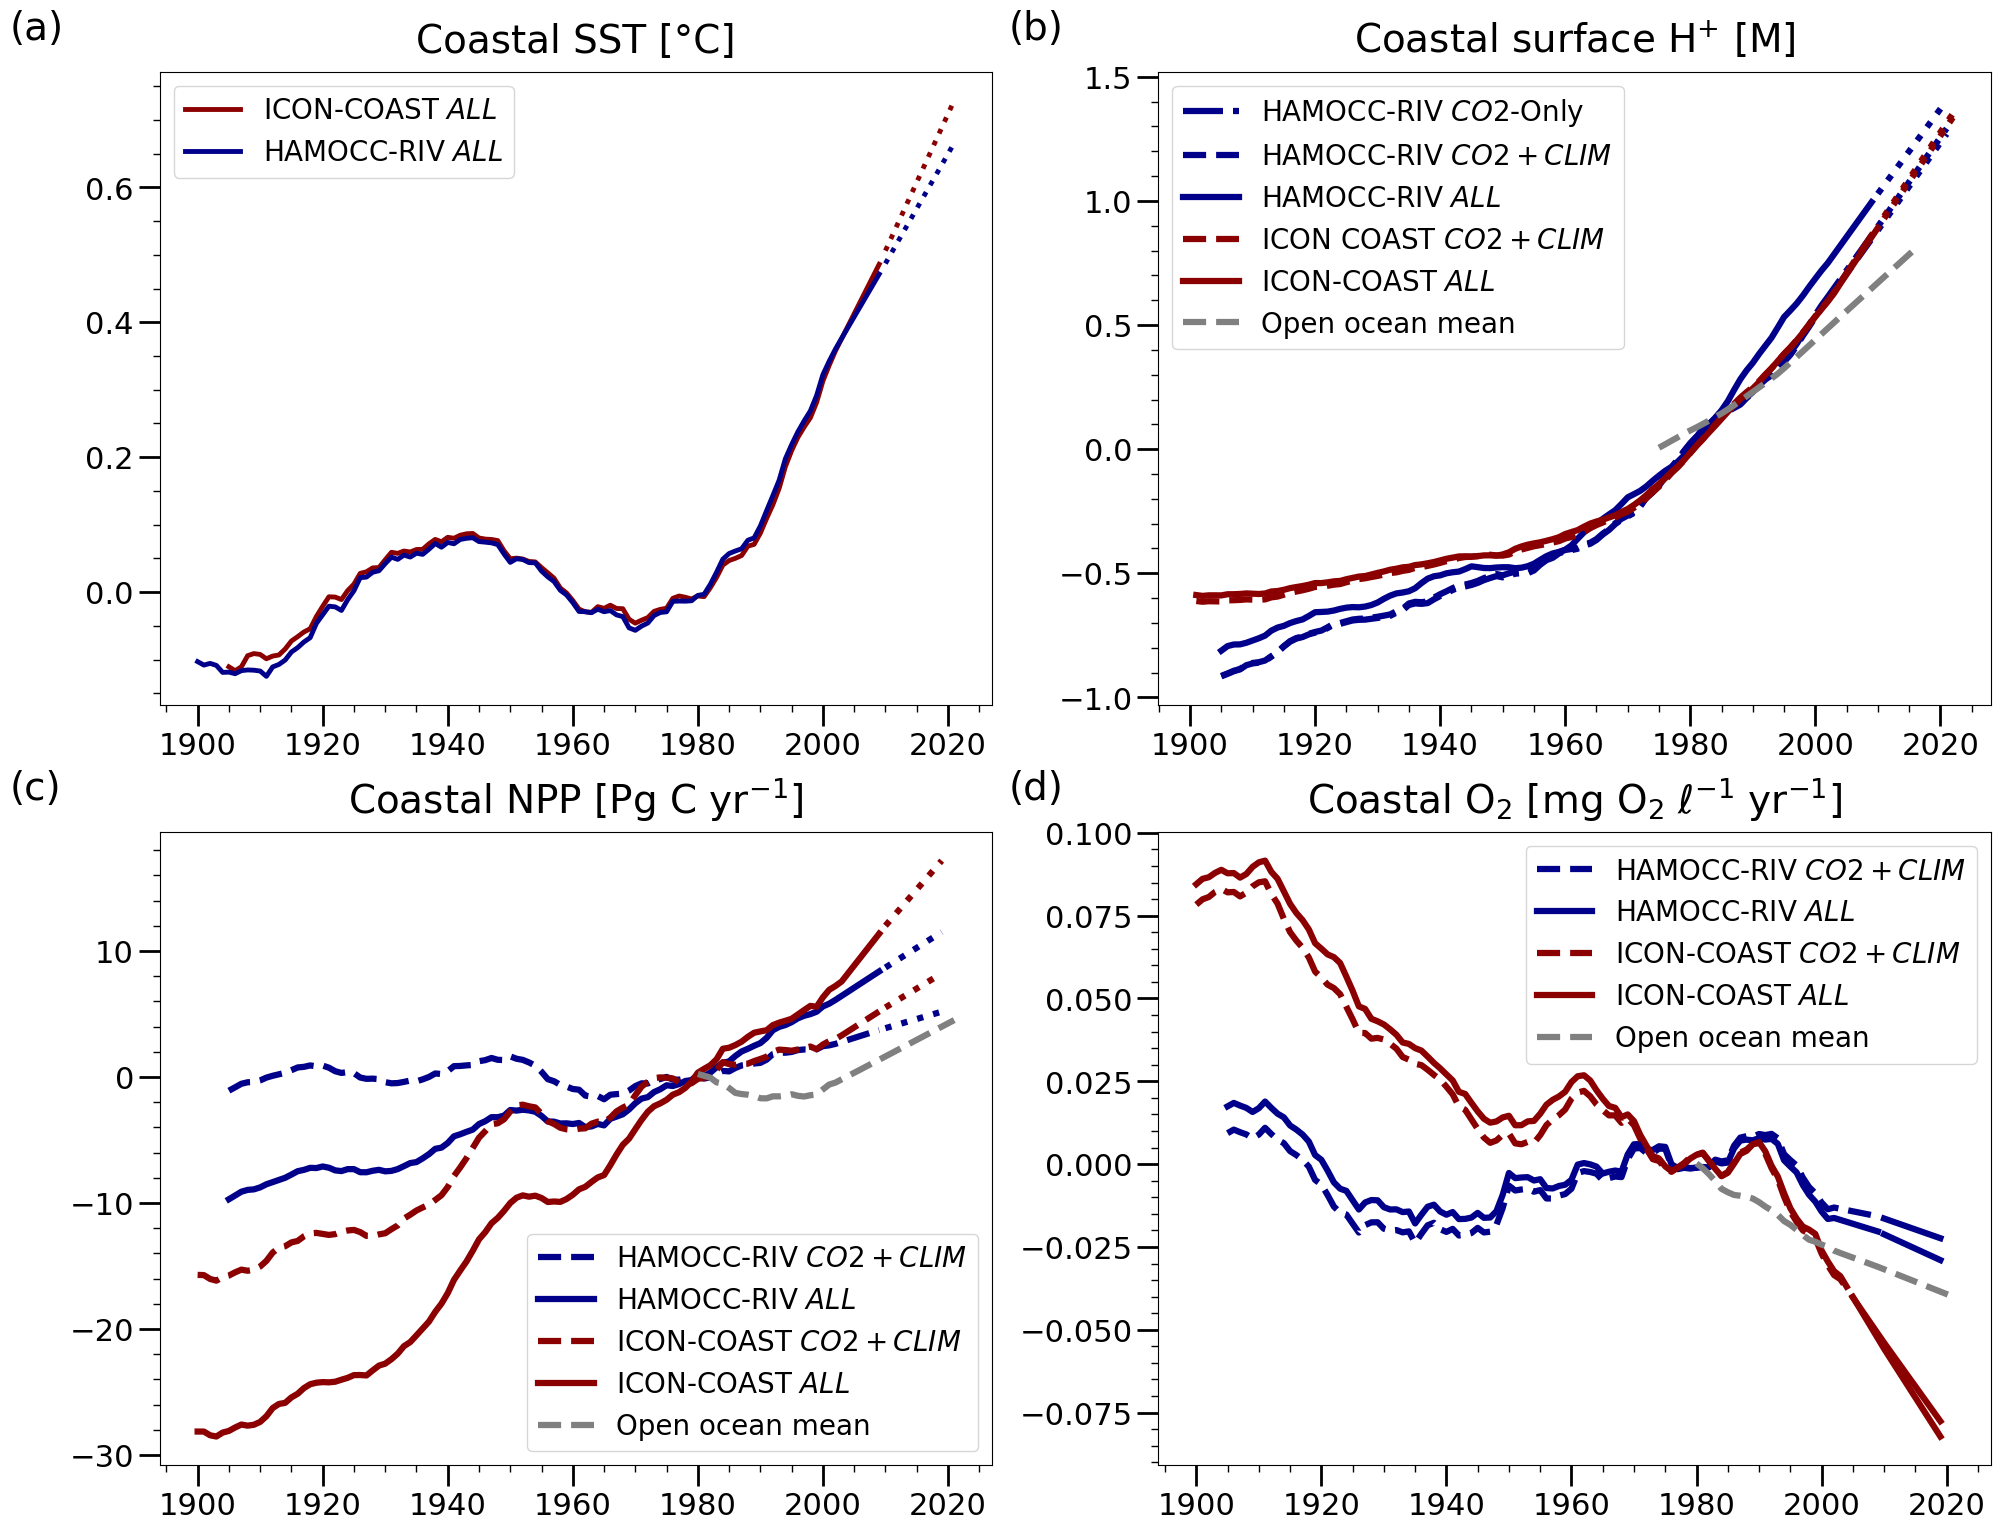

In [25]:
fig


In [11]:
data_npp={"coastal":0.48 / (22*10**12)*10**15 /1.7}
data_npp["global"]=1.029 / (361*10**12)*10**15 /1.7
data_oxygen={"coastal":0.08/0.032}
data_oxygen["global"]=0.067/0.08

print(data_npp)

{'coastal': 12.834224598930483, 'global': 1.6767150073325727}


/var/folders/0y/spqmc12x7jl4vpd6l453_34c0000gp/T/ipykernel_2849/2559282654.py:29: UserWarning: The handle <matplotlib.lines.Line2D object at 0x1216de8b0> has a label of '_' which cannot be automatically added to the legend.
  ax.legend(["Coastal Ocean","_","_","_","_","Open Ocean"],fontsize=20)
/var/folders/0y/spqmc12x7jl4vpd6l453_34c0000gp/T/ipykernel_2849/2559282654.py:29: UserWarning: The handle <matplotlib.lines.Line2D object at 0x1216de4f0> has a label of '_' which cannot be automatically added to the legend.
  ax.legend(["Coastal Ocean","_","_","_","_","Open Ocean"],fontsize=20)
/var/folders/0y/spqmc12x7jl4vpd6l453_34c0000gp/T/ipykernel_2849/2559282654.py:29: UserWarning: The handle <matplotlib.lines.Line2D object at 0x1216de7f0> has a label of '_' which cannot be automatically added to the legend.
  ax.legend(["Coastal Ocean","_","_","_","_","Open Ocean"],fontsize=20)
/var/folders/0y/spqmc12x7jl4vpd6l453_34c0000gp/T/ipykernel_2849/2559282654.py:29: UserWarning: The handle <matpl

TypeError: alpha must be numeric or None, not a string

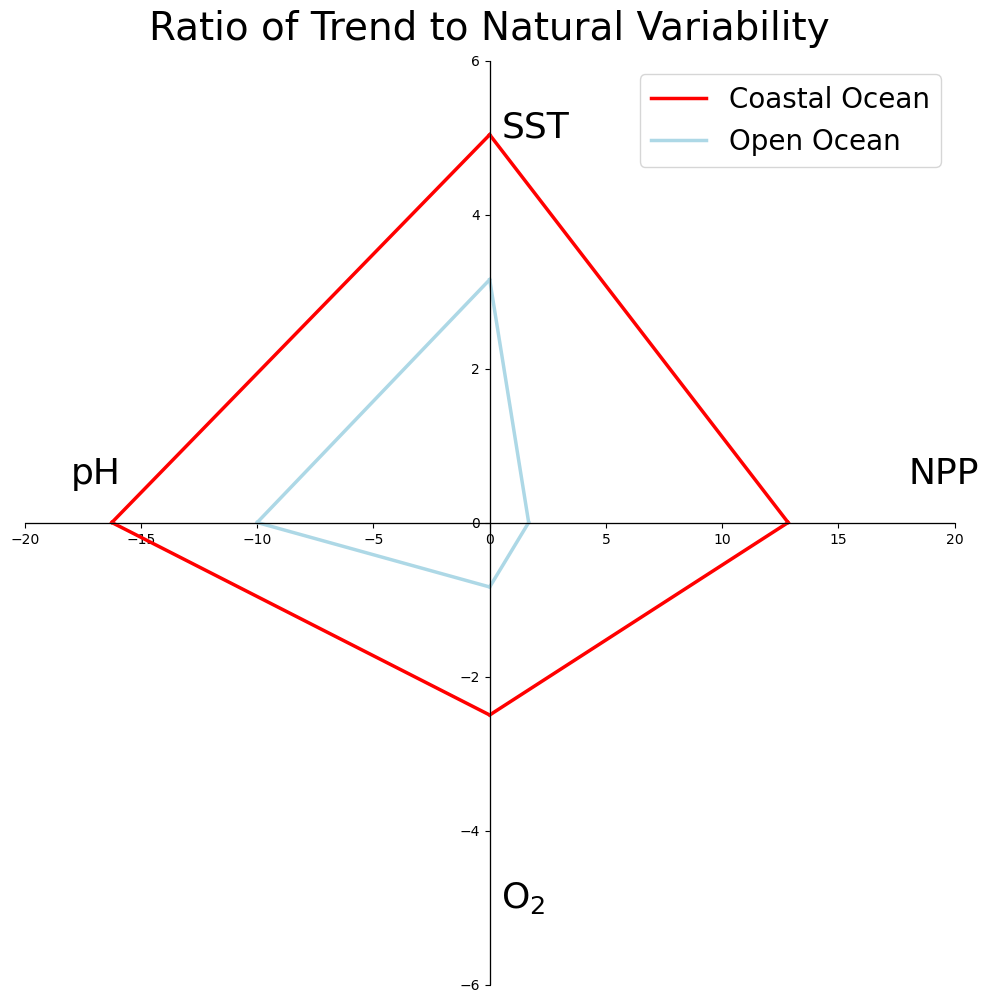

In [12]:
fig, ax =  plt.subplots(1,1,figsize=(12,12))

ax.plot([0,data_npp["coastal"]],[-data_oxygen["coastal"],0],color="red",linewidth=2.5)
ax.plot([data_npp["coastal"],0],[0,0.69/0.137],color="red",linewidth=2.5)
ax.plot([0,-1.3/0.08],[0.69/0.137,0],color="red",linewidth=2.5)
ax.plot([-1.3/0.08,0],[0,-data_oxygen["coastal"]],color="red",linewidth=2.5)

ax.plot([0,data_npp["global"]],[-data_oxygen["global"],0],color="lightblue",linewidth=2.5)
ax.plot([data_npp["global"],0],[0,0.47/0.149],color="lightblue",linewidth=2.5)
ax.plot([0,-0.6/0.06],[0.47/0.149,0],color="lightblue",linewidth=2.5)
ax.plot([-0.6/0.06,0],[0,-data_oxygen["global"]],color="lightblue",linewidth=2.5)

ax.set_xlim(-20,20)
ax.set_ylim(-6,6)

ax.axvline(x=0,linewidth=1, color='grey')
ax.axhline(y=0,linewidth=1, color='grey')

ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

ax.text(0.5, 5, 'SST', fontsize=26)
ax.text(18, 0.5, 'NPP', fontsize=26)
ax.text(-18, 0.5, 'pH', fontsize=26)
ax.text(0.5, -5, 'O$_{2}$', fontsize=26)

ax.legend(["Coastal Ocean","_","_","_","_","Open Ocean"],fontsize=20)
ax.set_title("Ratio of Trend to Natural Variability",fontsize=28,pad=15)

ax.fill_between([0,data_npp["coastal"]-0.5/0.46,data_npp["coastal"]+0.5/0.46],[-data_oxygen["coastal"]-1,intermediate_point(-data_oxygen["coastal"]-1,data_npp["coastal"],0.5/0.46,-1),0],[-data_oxygen["coastal"]+1,0,0], color="coral",alpha='0.5')
ax.fill_between([0,data_npp["coastal"]-0.5/0.46,data_npp["coastal"]+0.5/0.46],[0.69/0.137 + 0.1/0.137, intermediate_point(0.69/0.137 + 0.1/0.137,data_npp["coastal"],0.5/0.46,-1),0],[0.69/0.137 - 0.1/0.137,0,0], color="coral",alpha='0.5')
ax.fill_between([-1.3/0.08-0.1/0.08,-1.3/0.08+0.1/0.08,0],[0, intermediate_point(0.69/0.137+0.1/0.137,-1.9/0.08,-0.1/0.08,-1),0.69/0.137 + 0.1/0.137],[0,0,0.69/0.137 - 0.1/0.137], color="coral",alpha='0.5')
ax.fill_between([-1.3/0.08-0.1/0.08,-1.3/0.08+0.1/0.08,0],[0, intermediate_point(-data_oxygen["coastal"]-1,-1.3/0.08,-0.1/0.08,-1),-data_oxygen["coastal"]-1],[0,0,-data_oxygen["coastal"]+1], color="coral",alpha='0.5')


ax.fill_between([0,data_npp["global"]-1/1.5,data_npp["global"]+1/1],[-data_oxygen["global"]-1,intermediate_point(-data_oxygen["global"]-1,data_npp["global"],1/1.5,-1),0],[-data_oxygen["global"]+1,0,0], color="lightblue",alpha='0.5')
ax.fill_between([0,data_npp["global"]-1/1.5,data_npp["global"]+1/1],[0.47/0.149 + 0.1/0.137, intermediate_point(0.47/0.149+0.1/0.137,data_npp["global"],1/1.5,-1),0],[0.47/0.149+0.1/0.137,0,0], color="lightblue",alpha='0.5')
ax.fill_between([-0.6/0.06-0.1/0.06,-0.6/0.06+0.1/0.06,0],[0, intermediate_point(0.47/0.149+0.1/0.137,0.6/0.06,+0.1/0.06,-1),0.47/0.149 + 0.1/0.137],[0,0,0.47/0.149 - 0.1/0.137], color="lightblue",alpha='0.5')
ax.fill_between([-0.6/0.06-0.1/0.06,-0.6/0.06+0.1/0.06,0],[0, intermediate_point(-data_oxygen["global"]-1,-0.6/0.06,-0.1/0.06,-1),-data_oxygen["global"]-1],[0,0,-data_oxygen["global"]+1], color="lightblue",alpha='0.5')

ax.tick_params(axis='both', which='major', labelsize=22)

fig
fig.savefig("figures/coastal_openocean_rel.png",dpi=500,bbox_inches='tight',facecolor="white")

In [ ]:
var_npp_vgpm

In [ ]:
intermediate_point(-data_oxygen["coastal"]-1,data_npp["coastal"])


In [ ]:
(data_oxygen["coastal"]-1) / data_npp["coastal"] * data_npp["coastal"]

In [ ]:
intermediate_point(-data_oxygen["global"]-1,-0.9/0.06,-0.1/0.06,-1)

In [13]:
print("sst trend to natural variability",0.62/0.137)
print("hi trend to natural variability",-1.9/0.08)
print("NPP trend to natural variability",data_npp["coastal"])
print("oxygen trend to natural variability",-data_oxygen["coastal"])

sst trend to natural variability 4.525547445255474
hi trend to natural variability -23.75
NPP trend to natural variability 12.834224598930483
oxygen trend to natural variability -2.5
